In [18]:
from scipy.io import loadmat

loaded_dataset = loadmat("dataset_liver_bmodes_steatosis_assessment_IJCARS.mat")

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [20]:
def enhance_image(image):
    image = np.uint8(image)
    image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    scaled_image = (image / np.max(image)) * 255
    scaled_image = scaled_image.astype(np.uint8)

    # Apply adaptive histogram equalization (CLAHE) to enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(scaled_image.astype(np.uint8))

    # Apply bilateral filtering for noise reduction while preserving edges
    enhanced_image = cv2.bilateralFilter(enhanced_image, 15, 50, 50)

    # Apply sharpening using the Laplacian filter
    laplacian = cv2.Laplacian(enhanced_image, cv2.CV_64F)
    sharpened_image = np.uint8(np.clip(enhanced_image - 0.5 * laplacian, 0, 255))

    wiener_image = cv2.blur(sharpened_image, (3, 3))

    return wiener_image

## Setting up dataset and creating image files

In [21]:
data = loaded_dataset["data"]
data_records = {"id": [], "fat": [], "class": [], "images": []}

for record in range(55):
    id_ = data["id"][0][record][0][0]
    fat = data["fat"][0][record][0][0]
    cat = data["class"][0][record][0][0]
    imgs = data["images"][0][record]

    for index, im in enumerate(imgs):
        filename = f"{id_}_{cat}_{fat}_{index}.jpg"
        enhanced_im = enhance_image(im.astype(np.uint8))

        # cropping the image for region of interest
        roi_im = enhanced_im[300:700, 170:800]

        # to save images:
        # plt.imsave(f"og/{filename}", im.astype(np.uint8), cmap="grey")
        # plt.imsave(f"enh/{filename}", enhanced_im, cmap="grey")
        # plt.imsave(f"roi/{filename}", roi_im, cmap="grey")
        # roi_im = roi_im.astype(np.uint8)

        data_records["id"].append(id_)
        data_records["fat"].append(fat)
        data_records["class"].append(cat)
        data_records["images"].append(roi_im)
        # data_records["images"].append(enhanced_im)


print(f"Dimension of original image: {enhanced_im.shape}")
print(f"Dimension of region of interest: {roi_im.shape}")

df = pd.DataFrame(data_records)

Dimension of original image: (868, 1272)
Dimension of region of interest: (400, 630)


Reduced area by 77.19%

In [22]:
class_counts = df["class"].value_counts().sort_index()

# Print each class and its count
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

0: 170
1: 380


Class imbalance - 0:1 :~: 1:2

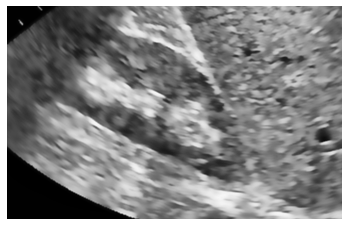

In [23]:
plt.imshow(data_records["images"][0], cmap="gray")
plt.axis("off")
plt.show()

### GLCM features

In [24]:
from skimage.feature import graycomatrix, graycoprops


# Define function to compute GLCM features for a single image
def compute_glcm_features(image):

    image = image.astype(np.uint8)
    distances = [1, 2, 3]  # Define distances for GLCM computation
    angles = [
        0,
        np.pi / 4,
        np.pi / 2,
        3 * np.pi / 4,
    ]  # Define angles for GLCM computation
    glcm = graycomatrix(
        image, distances=distances, angles=angles, symmetric=True, normed=True
    )
    # print(glcm.shape)
    # Compute GLCM properties
    contrast = graycoprops(glcm, "contrast").ravel()
    energy = graycoprops(glcm, "energy").ravel()
    homogeneity = graycoprops(glcm, "homogeneity").ravel()
    correlation = graycoprops(glcm, "correlation").ravel()

    # Concatenate GLCM features
    glcm_features = np.concatenate([contrast, energy, homogeneity, correlation])
    return glcm_features

In [25]:
images = df["images"].values[1]

# glcm_features = [compute_glcm_features(image.astype(np.uint8)) for image in images]
glcm_features = compute_glcm_features(images.astype(np.uint8))

print(f"Dimension of feature matrix of one image: {glcm_features.shape}")

Dimension of feature matrix of one image: (48,)


The other options in GLCM is dissimilarity and ASM

Here, we are trying to find the similarity and is handled by correlation. Dissimilarity often would produce noise or irrelevant information.
ASM at times is not often used for finding subtle differences. we concentrate on the subtle details for detecting liver steatosis.
Since these two contribute less to the model's performance, and it would **take more time to compute** these, it was decided that these features can be omitted. Even after adding them performance did not seem to improve, rather got worse.

Different angles and distance were also tried, to finally settle on these.

Each element in the `glcm_features` is the value calculated using a distance and an angle: this gives the relation between the pixels at the givn angle and distance

In [26]:
images = df["images"].values

print(
    f"Dimension of glcm feature of one image: {compute_glcm_features(images[0].astype(np.uint8)).shape}"
)
# Compute GLCM features for each image
glcm_features = [compute_glcm_features(image.astype(np.uint8)) for image in images]

# Concatenate GLCM features into a feature matrix
feature_matrix = np.array(glcm_features)
print(f"Dimension of feature matrix: {feature_matrix.shape}")

Dimension of glcm feature of one image: (48,)
Dimension of feature matrix: (550, 48)


## GLCM Theory
### Co-occurence matrix calculation

Dimension of `glcm` is (256, 256, 3, 4) = (number of grey levels, n of grey levels, n of distances, n of angles)


There are 256 grey levels because the range of greyscale is 0-256. (it is set in the `levels` argument in graycomatrix fn. The `levels` param should be greater than the max grey value)

A co-occ matrix is calculated for one (dist, angle) pair. So `glcm` is a collection of all 12 matrices for each combination of angles and dist (4*3). Each co-occ matrix is of size 255x255

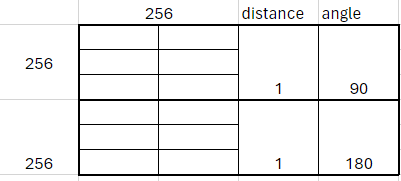

### Feature Calculation
Then the 4 properties are calculated: energy, contrast, homogeniety, similarity.

Each property calculates one value per matrix. So there will be 12 values (because of 12 matrices) for one property.

Since there are 4 properties, there will be 12*4=48 values for an image (as a vector)

So, `glcm_features` is of size (48,)

`feature_matrix` is concatenation of `glcm_features` of each image. Since we have 550 images, the dimension is (550, 48)

Now, we have come down from size of (550, 868, 1272) for original image to (550, 400, 630) for region of interest to (550, 48)


In [27]:
y = df["class"]

In [28]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [32]:
def display_results(metrics):
    
    print("Mean Accuracy:", metrics["mean_accuracy"])
    print("Mean ROC-AUC Score:", metrics["mean_auc"])
    print("Mean Confusion Matrix:\n", metrics["mean_conf_matrix"])
    print("Mean Classification Report:\n", metrics["classification_report"])

    class_names = ["No Disease", "Disease"]
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        metrics["mean_conf_matrix"],
        annot=True,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [35]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sns


def get_best_model(X, y, pca, num_folds=7):

    # Define the number of folds for cross-validation
    metrics = {}
    accuracy_scores = []
    auc_scores = []
    conf_matrices = []
    classification_reports = []

    # Initialize a StratifiedKFold object
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Initialize a Random Forest classifier
    clf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        criterion="entropy",
    )

    # Perform cross-validation
    for train_index, test_index in kf.split(X, y=y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply PCA to the training and test data
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Train the classifier
        clf.fit(X_train_pca, y_train)

        # Make predictions
        y_pred = clf.predict(X_test_pca)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        # Calculate ROC-AUC score
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrices.append(conf_matrix)

        # Calculate classification report
        cls_report = classification_report(y_test, y_pred)
        classification_reports.append(cls_report)

    metrics['mean_accuracy']  = np.mean(accuracy_scores) 
    metrics['best_accuracy'] = max(accuracy_scores)
    metrics['mean_auc'] = np.mean(auc_scores)
    metrics['mean_conf_matrix'] = np.mean(conf_matrices, axis=0)
    metrics['classification_report'] = classification_reports[0]
    
    display_results(metrics)


    return clf

Mean Accuracy: 0.9385926413576183
Mean ROC-AUC Score: 0.9133728878220921
Mean Confusion Matrix:
 [[16.14285714  2.85714286]
 [ 1.         42.85714286]]
Mean Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.93      0.98      0.96        44

    accuracy                           0.94        63
   macro avg       0.94      0.91      0.92        63
weighted avg       0.94      0.94      0.94        63



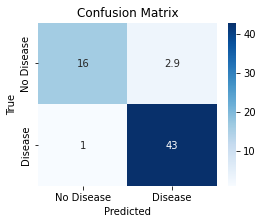

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix, y, test_size=0.2, random_state=40
)
# Initialize a PCA object
pca = PCA(n_components=11)
model = get_best_model(X_train, y_train, pca, 7)

# Mean Accuracy: 0.943200936288494
# Best Accuracy: 0.9841269841269841
# Mean ROC-AUC Score: 0.9150793650793653
# Mean Confusion Matrix:
#  [[15.28571429  2.71428571]
#  [ 0.85714286 44.        ]]

Test Accuracy: 0.9272727272727272


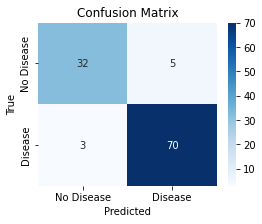

In [37]:
import seaborn as sns

# Evaluate the model on the testing data
pca.fit_transform(X_train)
X_test = pca.transform(X_test)
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


y_pred = model.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
class_names = ["No Disease", "Disease"]
plt.figure(figsize=(4, 3))
sns.heatmap(
    conf_matrix,
    annot=True,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 0.9181

PCA(MLE) gives better accuracy and stuff that any other methods

In [38]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sns


def get_best_model1(X, y, pca, num_folds=7):

    # Define the number of folds for cross-validation
    metrics = {}
    accuracy_scores = []
    auc_scores = []
    conf_matrices = []
    classification_reports = []

    # Initialize a StratifiedKFold object
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Initialize a Random Forest classifier
    clf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        criterion="entropy",
    )
    # Perform cross-validation
    for train_index, test_index in kf.split(X, y=y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply PCA to the training and test data
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Train the classifier
        clf.fit(X_train_pca, y_train)

        # Make predictions
        y_pred = clf.predict(X_test_pca)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        # Calculate ROC-AUC score
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrices.append(conf_matrix)

        # Calculate classification report
        cls_report = classification_report(y_test, y_pred)
        classification_reports.append(cls_report)
 # Calculate the mean accuracy score across all folds

    metrics['mean_accuracy']  = np.mean(accuracy_scores) 
    metrics['best_accuracy'] = max(accuracy_scores)
    metrics['mean_auc'] = np.mean(auc_scores)
    metrics['mean_conf_matrix'] = np.mean(conf_matrices, axis=0)
    metrics['classification_report'] = classification_reports[0]
    
    display_results(metrics)


    return clf

Mean Accuracy: 0.9454319362153463
Mean ROC-AUC Score: 0.9071428571428571
Mean Confusion Matrix:
 [[14.71428571  3.28571429]
 [ 0.14285714 44.71428571]]
Mean Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88        18
           1       0.92      1.00      0.96        45

    accuracy                           0.94        63
   macro avg       0.96      0.89      0.92        63
weighted avg       0.94      0.94      0.93        63



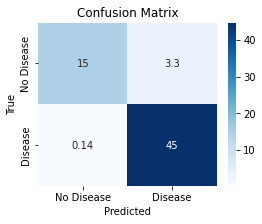

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix, y, test_size=0.2, random_state=42
)
# Initialize a PCA object
pca = PCA(n_components="mle")
model = get_best_model1(X_train, y_train, pca, 7)

# Mean Accuracy: 0.9454319362153463
# Best Accuracy: 0.9841269841269841
# Mean ROC-AUC Score: 0.9071428571428571
# Mean Confusion Matrix:
#  [[14.71428571  3.28571429]
#  [ 0.14285714 44.71428571]]

Test Accuracy: 0.9


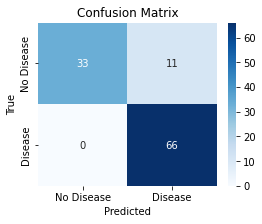

In [40]:
import seaborn as sns

# Evaluate the model on the testing data
pca.fit_transform(X_train)
X_test = pca.transform(X_test)
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


y_pred = model.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
class_names = ["No Disease", "Disease"]
plt.figure(figsize=(4, 3))
sns.heatmap(
    conf_matrix,
    annot=True,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# test acc 0.9

In [41]:
import joblib

joblib.dump(model, r"..\models\trained_model.pkl")
joblib.dump(pca, r"..\models\pca_preprocessor.pkl")

['..\\models\\pca_preprocessor.pkl']

In [42]:
loaded_model = joblib.load(r"..\models\trained_model.pkl")
loaded_pca = joblib.load(r"..\models\pca_preprocessor.pkl")

import os

# Specify the directory path
directory = r"C:\Lakshmi\college\nafld-detection\us_scan_model\og"

# Iterate through the files in the directory
for filename in os.listdir(directory)[90:120]:
    filepath = os.path.join(directory, filename)
    if os.path.isfile(filepath):
        print(filepath)
        new_features_pca = preprocess_img(filepath)
        print(loaded_model.predict(new_features_pca))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Lakshmi\\college\\nafld-detection\\us_scan_model\\og'

## CNN Model; 3 crossfold validation

In [43]:
from sklearn.model_selection import train_test_split

X = np.array(df["images"].tolist())
y = np.array(df["class"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [44]:
# import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as snss
import numpy as np

model = Sequential(
    [
        Conv2D(
            32, (3, 3), activation="relu", input_shape=(X[0].shape[0], X[0].shape[1], 1)
        ),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)
print("meo")
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

meo


In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 628, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 314, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 312, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 98, 156, 64)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 978432)            0         
                                                                 
 dense (Dense)               (None, 64)                6

In [46]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
14/14 [==============================] - 56s 4s/step - loss: 1084.2719 - accuracy: 0.5909
Epoch 2/10
14/14 [==============================] - 56s 4s/step - loss: 8.9673 - accuracy: 0.6182
Epoch 3/10
14/14 [==============================] - 57s 4s/step - loss: 0.5350 - accuracy: 0.7500
Epoch 4/10
14/14 [==============================] - 58s 4s/step - loss: 0.4381 - accuracy: 0.8000
Epoch 5/10
14/14 [==============================] - 56s 4s/step - loss: 0.6984 - accuracy: 0.8159
Epoch 6/10
14/14 [==============================] - 52s 4s/step - loss: 0.1492 - accuracy: 0.9500
Epoch 7/10
14/14 [==============================] - 52s 4s/step - loss: 0.0239 - accuracy: 0.9977
Epoch 8/10
14/14 [==============================] - 52s 4s/step - loss: 0.0027 - accuracy: 1.0000
Epoch 9/10
14/14 [==============================] - 53s 4s/step - loss: 1.4939e-04 - accuracy: 1.0000
Epoch 10/10
14/14 [==============================] - 54s 4s/step - loss: 6.0420e-05 - accuracy: 1.0000


In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import StratifiedKFold
import numpy as np


def create_model(input_shape):
    model = Sequential(
        [
            Conv2D(
                32,
                (3, 3),
                activation="relu",
                input_shape=(input_shape[0], input_shape[1], 1),
            ),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(64, activation="relu"),
            Dense(1, activation="sigmoid"),
        ]
    )
    return model


num_folds = 3
epochs = 10
batch_size = 32

accuracy_scores = []
loss_scores = []

kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model(input_shape=X_train[0].shape)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1
    )

    loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
    loss_scores.append(loss)
    accuracy_scores.append(accuracy)

mean_loss = np.mean(loss_scores)
mean_accuracy = np.mean(accuracy_scores)

print("Mean Loss:", mean_loss)
print("Mean Accuracy:", mean_accuracy)

Epoch 1/10
12/12 [==============================] - 45s 4s/step - loss: 1922.1854 - accuracy: 0.5929
Epoch 2/10
12/12 [==============================] - 43s 4s/step - loss: 5.5693 - accuracy: 0.5792
Epoch 3/10
12/12 [==============================] - 43s 4s/step - loss: 0.5480 - accuracy: 0.7268
Epoch 4/10
12/12 [==============================] - 44s 4s/step - loss: 0.4665 - accuracy: 0.7131
Epoch 5/10
12/12 [==============================] - 43s 4s/step - loss: 0.4040 - accuracy: 0.7432
Epoch 6/10
12/12 [==============================] - 45s 4s/step - loss: 0.3592 - accuracy: 0.8087
Epoch 7/10
12/12 [==============================] - 45s 4s/step - loss: 0.3211 - accuracy: 0.8279
Epoch 8/10
12/12 [==============================] - 46s 4s/step - loss: 0.2893 - accuracy: 0.8907
Epoch 9/10
12/12 [==============================] - 45s 4s/step - loss: 0.2602 - accuracy: 0.9208
Epoch 10/10
6/6 [==============================] - 6s 941ms/step - loss: 0.4377 - accuracy: 0.7663
Epoch 1/10
12/12

In [48]:
y_pred_probs = model.predict(X_test)

y_pred_classes = (y_pred_probs > 0.5).astype(int)

4/4 [==============================] - 3s 740ms/step


In [49]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

4/4 - 3s - loss: 0.0422 - accuracy: 0.9818 - 3s/epoch - 741ms/step


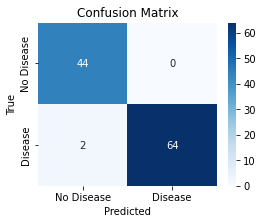

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ["No Disease", "Disease"]
mean_conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(4, 3))
sns.heatmap(
    mean_conf_matrix,
    annot=True,
    cmap="Blues",
    fmt="g",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [51]:
print(roc_auc_score(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

0.9848484848484849
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        44
           1       1.00      0.97      0.98        66

    accuracy                           0.98       110
   macro avg       0.98      0.98      0.98       110
weighted avg       0.98      0.98      0.98       110



In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import StratifiedKFold
import numpy as np


def create_model(input_shape, dropout_rate):
    model = Sequential(
        [
            Conv2D(
                32,
                (3, 3),
                activation="relu",
                input_shape=(input_shape[0], input_shape[1], 1),
            ),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(64, activation="relu"),
            Dropout(dropout_rate),  # Dropout layer
            Dense(1, activation="sigmoid"),
        ]
    )
    return model


num_folds = 3
epochs = 10
batch_size = 16
dropout_rate = 0.2

accuracy_scores = []
loss_scores = []

kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model(input_shape=X_train[0].shape, dropout_rate=dropout_rate)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        validation_data=(X_val, y_val),
    )

    loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
    loss_scores.append(loss)
    accuracy_scores.append(accuracy)

mean_loss = np.mean(loss_scores)
mean_accuracy = np.mean(accuracy_scores)

print("Mean Loss:", mean_loss)
print("Mean Accuracy:", mean_accuracy)

Epoch 1/10
23/23 [==============================] - 61s 3s/step - loss: 765.0180 - accuracy: 0.6311 - val_loss: 0.6068 - val_accuracy: 0.6957
Epoch 2/10
23/23 [==============================] - 62s 3s/step - loss: 0.5200 - accuracy: 0.7432 - val_loss: 0.4835 - val_accuracy: 0.7663
Epoch 3/10
23/23 [==============================] - 63s 3s/step - loss: 0.2997 - accuracy: 0.8770 - val_loss: 0.2817 - val_accuracy: 0.8913
Epoch 4/10
23/23 [==============================] - 58s 3s/step - loss: 0.0980 - accuracy: 0.9699 - val_loss: 0.2314 - val_accuracy: 0.9130
Epoch 5/10
23/23 [==============================] - 57s 3s/step - loss: 0.2561 - accuracy: 0.9672 - val_loss: 0.2465 - val_accuracy: 0.9076
Epoch 6/10
23/23 [==============================] - 58s 3s/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.4745 - val_accuracy: 0.9185
Epoch 7/10
23/23 [==============================] - 61s 3s/step - loss: 0.0048 - accuracy: 0.9973 - val_loss: 0.3605 - val_accuracy: 0.9293
Epoch 8/10
23/23 [

In [53]:
y_pred_probs = model.predict(X_test)

y_pred_classes = (y_pred_probs > 0.5).astype(int)

4/4 [==============================] - 3s 769ms/step


4/4 - 3s - loss: 0.0718 - accuracy: 0.9727 - 3s/epoch - 804ms/step


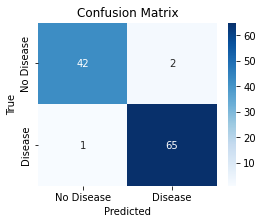

In [54]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

class_names = ["No Disease", "Disease"]
mean_conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(4, 3))
sns.heatmap(
    mean_conf_matrix,
    annot=True,
    cmap="Blues",
    fmt="g",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [55]:
print(roc_auc_score(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

0.9696969696969697
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.97      0.98      0.98        66

    accuracy                           0.97       110
   macro avg       0.97      0.97      0.97       110
weighted avg       0.97      0.97      0.97       110



In [ ]:
# model.save("good_model.h5")

In [56]:
import cv2
import numpy as np
from keras.models import load_model

# Load the input image
new_inp_img = cv2.imread(
    r"C:\Lakshmi\college\nafld-detection\us_scan_model\roi\52_1_80_5.jpg",
    cv2.IMREAD_GRAYSCALE,
)

# Preprocess the input image (resize, normalize, etc.)
# Perform any necessary preprocessing steps here...

# Ensure the input image has the correct shape and data type
new_inp_img = new_inp_img.astype(np.float32)  # Adjust the data type if needed

# Expand the dimensions to match the input shape expected by the model
new_inp_img = np.expand_dims(new_inp_img, axis=0)  # Add batch dimension

# Make predictions using the model

n_model = load_model("good_model.h5")

predictions = model.predict(new_inp_img)


# Print or use the predictions as needed
print(predictions)

AttributeError: 'NoneType' object has no attribute 'astype'